In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

Error loading files: [Errno 2] No such file or directory: '../testing-results/lora_Qwen2.5_14B_model-5000-preflop_cleaned.csv'


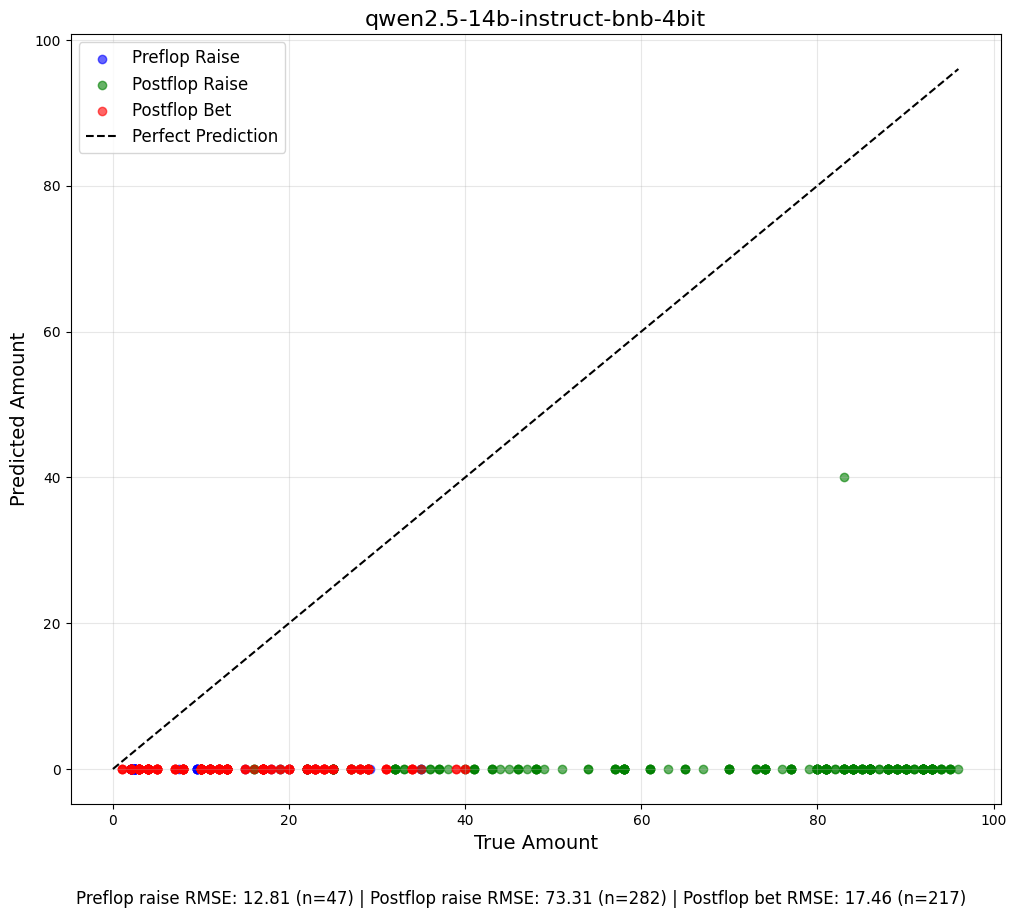

In [3]:
def create_combined_scatter_plot(model_name, save_img=True):
    """
    Create a combined scatter plot for preflop and postflop data with different colors.
    
    Args:
        preflop_model (str): Name of the preflop model
        postflop_model (str): Name of the postflop model
    """
    # Load the cleaned data
    preflop_file_path = f'../testing-results/{model_name}-preflop_cleaned.csv'
    postflop_file_path = f'../testing-results/{model_name}-postflop_cleaned.csv'
    
    try:
        preflop_df = pd.read_csv(preflop_file_path)
        postflop_df = pd.read_csv(postflop_file_path)
    except FileNotFoundError as e:
        print(f"Error loading files: {e}")
        return
    
    # Create a new figure
    plt.figure(figsize=(12, 10))
    
    # Filter data for raises in preflop
    preflop_raises = preflop_df[(preflop_df['True_Action'] == 'raise') & 
                               (preflop_df['Pred_Action'] == 'raise')]
    preflop_raises = preflop_raises.dropna(subset=['True_Amount', 'Pred_Amount'])
    
    # Filter data for raises and bets in postflop
    postflop_raises = postflop_df[(postflop_df['True_Action'] == 'raise') & 
                                 (postflop_df['Pred_Action'] == 'raise')]
    postflop_raises = postflop_raises.dropna(subset=['True_Amount', 'Pred_Amount'])
    
    postflop_bets = postflop_df[(postflop_df['True_Action'] == 'bet') & 
                               (postflop_df['Pred_Action'] == 'bet')]
    postflop_bets = postflop_bets.dropna(subset=['True_Amount', 'Pred_Amount'])
    
    # Plot the data points with different colors
    plt.scatter(preflop_raises['True_Amount'], preflop_raises['Pred_Amount'], 
                alpha=0.6, color='blue', label='Preflop Raise')
    plt.scatter(postflop_raises['True_Amount'], postflop_raises['Pred_Amount'], 
                alpha=0.6, color='green', label='Postflop Raise')
    plt.scatter(postflop_bets['True_Amount'], postflop_bets['Pred_Amount'], 
                alpha=0.6, color='red', label='Postflop Bet')
    
    # Calculate metrics for display
    metrics_text = ""
    
    if len(preflop_raises) > 0:
        preflop_raise_rmse = np.sqrt(((preflop_raises['True_Amount'] - preflop_raises['Pred_Amount']) ** 2).mean())
        metrics_text += f"Preflop raise RMSE: {preflop_raise_rmse:.2f} (n={len(preflop_raises)})"
    
    if len(postflop_raises) > 0:
        postflop_raise_rmse = np.sqrt(((postflop_raises['True_Amount'] - postflop_raises['Pred_Amount']) ** 2).mean())
        metrics_text += f" | Postflop raise RMSE: {postflop_raise_rmse:.2f} (n={len(postflop_raises)})"
    
    if len(postflop_bets) > 0:
        postflop_bet_rmse = np.sqrt(((postflop_bets['True_Amount'] - postflop_bets['Pred_Amount']) ** 2).mean())
        metrics_text += f" | Postflop bet RMSE: {postflop_bet_rmse:.2f} (n={len(postflop_bets)})"
    
    # Add perfect prediction line
    all_data = pd.concat([preflop_raises, postflop_raises, postflop_bets])
    if len(all_data) > 0:
        max_val = max(all_data['True_Amount'].max(), all_data['Pred_Amount'].max())
        min_val = min(all_data['True_Amount'].min(), all_data['Pred_Amount'].min())
        plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction')
    
    # Set labels and title
    plt.title(f'{model_name}', fontsize=16)
    plt.xlabel('True Amount', fontsize=14)
    plt.ylabel('Predicted Amount', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    
    # Add metrics text at the bottom
    plt.figtext(0.5, 0.01, metrics_text, ha="center", fontsize=12)
    
    if save_img: 
        # Save the plot
        combined_image_path = f'/Users/weber/Github/COMP0258/testing-results/{model_name}_combined_amount_prediction.png'
        plt.savefig(combined_image_path, bbox_inches='tight')
        plt.close()    
        print(f"Combined scatter plot saved to {combined_image_path}")

# Example usage
models_list = [
    "qwen2.5-14b-instruct-bnb-4bit",
    "lora_Qwen2.5_14B_model-5000",
    # Add more model pairs as needed
]

for model in models_list:
    create_combined_scatter_plot(model, save_img=False)

Grid comparison saved to ../visualizations/numerical_prediction_pretrained.png


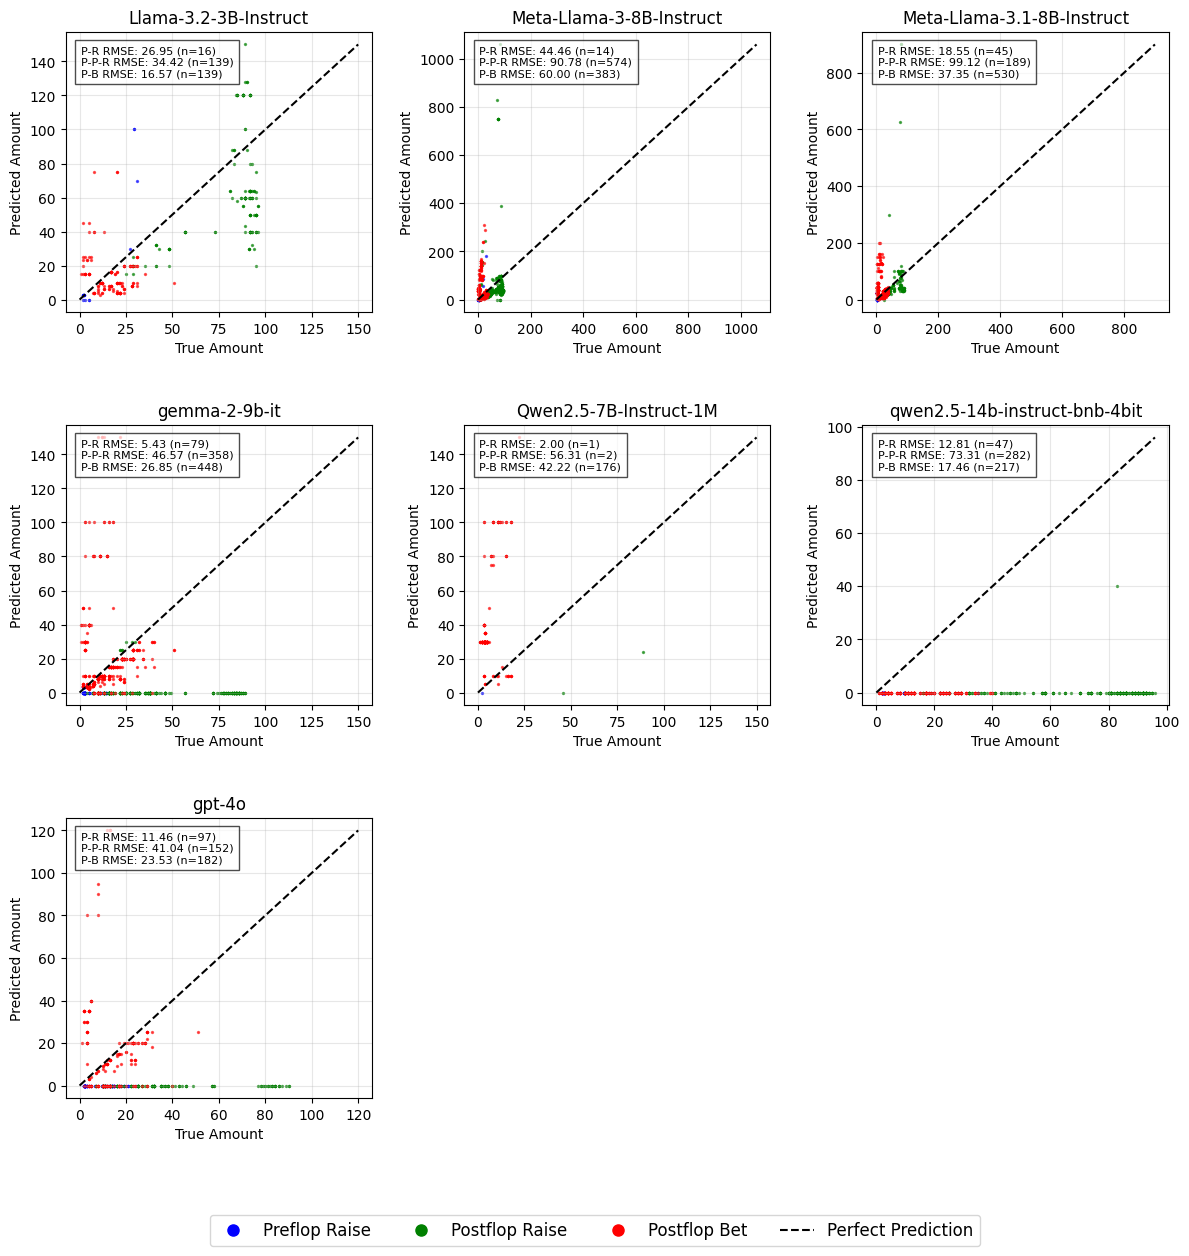

Grid comparison saved to ../visualizations/numerical_prediction_finetuned.png


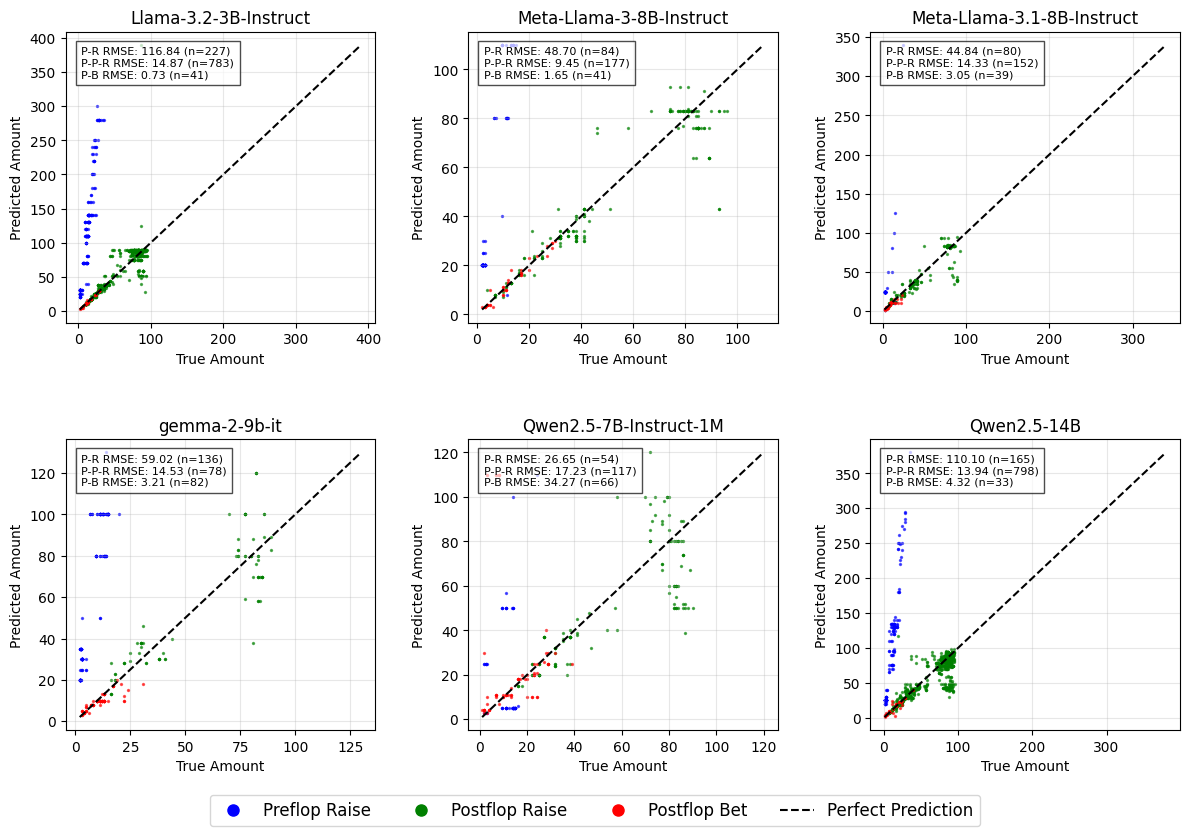

In [4]:
def create_grid_comparison(models_list, cols_per_row=5, save_img_name = None):
    """
    Create a grid of scatter plots for multiple models.
    
    Args:
        models_list (list): List of model names to plot
        cols_per_row (int): Number of plots per row
        save_img (bool): Whether to save the resulting image
    """
    # Calculate grid dimensions
    n_models = len(models_list)
    n_rows = (n_models + cols_per_row - 1) // cols_per_row  # Ceiling division

    # Create figure and axes
    fig, axes = plt.subplots(n_rows, cols_per_row,
                             figsize=(cols_per_row * 4, n_rows * 4))
    axes = axes.flatten() if n_rows * cols_per_row > 1 else [axes]

    # Process each model
    for i, model_name in enumerate(models_list):
        # Use the current axis
        plt.sca(axes[i])

        # Load the data
        preflop_file_path = f'../testing-results/{model_name}-preflop_cleaned.csv'
        postflop_file_path = f'../testing-results/{model_name}-postflop_cleaned.csv'

        try:
            preflop_df = pd.read_csv(preflop_file_path)
            postflop_df = pd.read_csv(postflop_file_path)

            # Filter data for raises in preflop
            preflop_raises = preflop_df[(preflop_df['True_Action'] == 'raise') &
                                        (preflop_df['Pred_Action'] == 'raise')]
            preflop_raises = preflop_raises.dropna(
                subset=['True_Amount', 'Pred_Amount'])

            # Filter data for raises and bets in postflop
            postflop_raises = postflop_df[(postflop_df['True_Action'] == 'raise') &
                                          (postflop_df['Pred_Action'] == 'raise')]
            postflop_raises = postflop_raises.dropna(
                subset=['True_Amount', 'Pred_Amount'])

            postflop_bets = postflop_df[(postflop_df['True_Action'] == 'bet') &
                                        (postflop_df['Pred_Action'] == 'bet')]
            postflop_bets = postflop_bets.dropna(
                subset=['True_Amount', 'Pred_Amount'])

            dot_size = 2
            # Plot the data points with different colors
            axes[i].scatter(preflop_raises['True_Amount'], preflop_raises['Pred_Amount'],
                            alpha=0.6, color='blue', label='Preflop Raise', s=dot_size)
            axes[i].scatter(postflop_raises['True_Amount'], postflop_raises['Pred_Amount'],
                            alpha=0.6, color='green', label='Postflop Raise', s=dot_size)
            axes[i].scatter(postflop_bets['True_Amount'], postflop_bets['Pred_Amount'],
                            alpha=0.6, color='red', label='Postflop Bet', s=dot_size)

            # Calculate metrics for display
            metrics_text = ""

            if len(preflop_raises) > 0:
                preflop_raise_rmse = np.sqrt(
                    ((preflop_raises['True_Amount'] - preflop_raises['Pred_Amount']) ** 2).mean())
                metrics_text += f"P-R RMSE: {preflop_raise_rmse:.2f} (n={len(preflop_raises)})"

            if len(postflop_raises) > 0:
                postflop_raise_rmse = np.sqrt(
                    ((postflop_raises['True_Amount'] - postflop_raises['Pred_Amount']) ** 2).mean())
                metrics_text += f"\nP-P-R RMSE: {postflop_raise_rmse:.2f} (n={len(postflop_raises)})"

            if len(postflop_bets) > 0:
                postflop_bet_rmse = np.sqrt(
                    ((postflop_bets['True_Amount'] - postflop_bets['Pred_Amount']) ** 2).mean())
                metrics_text += f"\nP-B RMSE: {postflop_bet_rmse:.2f} (n={len(postflop_bets)})"

            # Add perfect prediction line
            all_data = pd.concat(
                [preflop_raises, postflop_raises, postflop_bets])
            if len(all_data) > 0:
                max_val = max(all_data['True_Amount'].max(),
                              all_data['Pred_Amount'].max())
                min_val = min(all_data['True_Amount'].min(),
                              all_data['Pred_Amount'].min())
                axes[i].plot([min_val, max_val], [min_val, max_val], 'k--')

            # Set title and labels
            model_display_name = model_name.split(
                '_')[0] if '_' in model_name else model_name
            model_display_name = model_display_name.split(
                '-lr')[0] if '-lr' in model_display_name else model_display_name
            model_display_name = model_display_name.replace(
                'lora-', '') if 'lora-' in model_display_name else model_display_name
            axes[i].set_title(f'{model_display_name}', fontsize=12)
            axes[i].set_xlabel('True Amount', fontsize=10)
            axes[i].set_ylabel('Predicted Amount', fontsize=10)
            axes[i].grid(True, alpha=0.3)

            # Add metrics text in the plot corner
            axes[i].text(0.05, 0.95, metrics_text, transform=axes[i].transAxes,
                         va='top', fontsize=8, bbox=dict(facecolor='white', alpha=0.7))

        except FileNotFoundError as e:
            axes[i].text(0.5, 0.5, f"Data not found for\n{model_name}",
                         ha='center', va='center', fontsize=10)
            axes[i].set_xticks([])
            axes[i].set_yticks([])

    # Hide unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    # Add a common legend at the bottom of the figure
    handles, labels = [], []
    legend_items = [('blue', 'Preflop Raise'), ('green', 'Postflop Raise'),
                    ('red', 'Postflop Bet'), ('k--', 'Perfect Prediction')]
    for color, label in legend_items:
        if color == 'k--':
            handles.append(plt.Line2D([0], [0], color='black', linestyle='--'))
        else:
            handles.append(plt.Line2D(
                [0], [0], marker='o', color=color, linestyle='None', markersize=8))
        labels.append(label)

    fig.legend(handles, labels, loc='lower center', ncol=4,
               bbox_to_anchor=(0.5,-0.05), fontsize=12)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.08, wspace=0.3, hspace=0.4)

    if save_img_name:
        grid_image_path = f'../visualizations/{save_img_name}.png'
        plt.savefig(grid_image_path, bbox_inches='tight')
        print(f"Grid comparison saved to {grid_image_path}")

    plt.show()

# Example usage
models_list_pretrained = [
    "Llama-3.2-3B-Instruct",
    "Meta-Llama-3-8B-Instruct",
    "Meta-Llama-3.1-8B-Instruct",
    "gemma-2-9b-it",
    "Qwen2.5-7B-Instruct-1M",
    "qwen2.5-14b-instruct-bnb-4bit",
    "gpt-4o",
]
    
models_list_finetuned = [
    "lora-Llama-3.2-3B-Instruct-lr-5",
    "lora-Meta-Llama-3-8B-Instruct-lr-6",
    "lora-Meta-Llama-3.1-8B-Instruct",
    "lora-gemma-2-9b-it",
    "lora-Qwen2.5-7B-Instruct-1M",
    "lora-Qwen2.5-14B_model-5000",
    
    # Add more models as needed
]


create_grid_comparison(models_list_pretrained, cols_per_row=3,
                       save_img_name="numerical_prediction_pretrained")
create_grid_comparison(models_list_finetuned, cols_per_row=3,
                       save_img_name="numerical_prediction_finetuned")